### Clustering & Retrieval of Wikipedia Documents 

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. Using the People Wikipedia data, you can find out nearest neighbors for various people based on their wikipedia information. To find relevant documents you typically decide on a notion of similarity and find the documents that are most similar. When properly executed, clustering uncovers valuable insights from a set of unlabeled documents. This notebook covers the following clustering algorithms:
* k-Nearest Neighbors
* k-means

In the notebook you will:
* Apply standard preprocessing techniques on Wikipedia text data
* Using clustering methods to group Wikipedia documents
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Evaluate cluster performance
* Explore and interpret the results, including topic keywords and topic assignments for documents
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF

Next time, we will cover:
* Mixture Models
* Latent Dirichlet Allocation (LDA)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

## Import People Wikipedia Dataset

In [2]:
wiki = pd.read_csv('../datasets/people_wiki.csv')

Similar to prior notebooks, let's explore the statistics of missing data

Compute missing statistics

In [3]:
top_n=3
missing_column_counts = wiki[wiki.columns[wiki.isnull().any()]].isnull().sum()
max_idxs = np.argsort(missing_column_counts.to_numpy())[::-1][:top_n]

num_categories = wiki.isna().any(axis=0).sum()
average_per_category = wiki.isna().sum().sum()/len(wiki.columns)
top_missing_categories = wiki.columns[max_idxs[:top_n]].to_numpy()

print('Number of categories: {}'.format(num_categories))
print('Average missing values per categories: {}'.format(average_per_category))
print('Categories with top {} missing values: {}'.format(top_n,top_missing_categories))

Number of categories: 0
Average missing values per categories: 0.0
Categories with top 3 missing values: []


Although, having missing data is ideal, it does not happen much in practice (we got lucky). 

In [4]:
print('There are {} articles in the Wikipedia dataset'.format(len(wiki)))
wiki = wiki[:1000] # explore first 1000 articles

There are 42786 articles in the Wikipedia dataset


Inspect the People's Wikipedia dataset

In [5]:
wiki

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
995,<http://dbpedia.org/resource/Tantely_Andrianar...,Tantely Andrianarivo,ren tantely gabrio andrianarivo born 25 may 19...
996,<http://dbpedia.org/resource/Terry_Wogan>,Terry Wogan,sir michael terence terry wogan kbe dl born 3 ...
997,<http://dbpedia.org/resource/Mike_LaValliere>,Mike LaValliere,michael eugene mike lavalliere born august 18 ...
998,<http://dbpedia.org/resource/Benjamin_Vogt_(po...,Benjamin Vogt (poet),benjamin vogt is a poet and essayist from linc...


Let's explore one article at index 269 about 

In [6]:
print(wiki['name'][269])
print(wiki['text'][269])

Kerr Cuhulain
kerr cuhulain is the pen name of canadian occult author and retired detective constable charles ennis a former child abuse investigator he is the author of several articles on child abuse investigation that appeared in law order magazine a former air force officer cuhulain was a police officer for over 28 years a police dispatcher for another 8 years and a wiccan for over forty hes served on the swat team gang crime unit and hostage negotiation teambetter known to the pagan community by his wiccan name kerr cuhulain ennis was the first wiccan police officer to go public about his beliefs 36 years ago he is the former preceptor general of officers of avalon a nonprofit benevolent association for pagan and wiccan law enforcement firefighting and emergency medical personnel and their families he is a frequent contributor to the witches voice networking website and has applied his abilities as an investigative journalist to the histories of several controversial individuals i

## Explore Wikipedia dataset

### Descriptive Statistics
- total_num_words: Total number of words
- average_word_count: Average word count per articles
- top_n_articles_most_words: Top n articles with most words
- top_n_articles_least_words: Top n articles with and least words

Drop Nans before exploring the dataset 

In [7]:
num_obs=len(wiki)
wiki = wiki.dropna()
print('{} articles have been removed from the dataset'.format(num_obs-len(wiki)))

0 articles have been removed from the dataset


In [8]:
wiki.isna().sum()

URI     0
name    0
text    0
dtype: int64

Compute descriptive statistic about Wikipedia articles

In [9]:
top_n=3
wiki['num_words'] = wiki['text'].apply(lambda sentence: len(sentence.split()))
total_num_words = wiki['num_words'].sum()
average_word_count = total_num_words / len(wiki)
top_n_reviews_most_words = wiki.nlargest(top_n, 'num_words')['text']
top_n_names_most_words = wiki.nlargest(top_n, 'num_words')['name']

top_n_reviews_least_words = wiki.nsmallest(top_n, 'num_words')['text']
top_n_names_least_words = wiki.nsmallest(top_n, 'num_words')['name']

In [10]:
print('Total number of words: {}'.format(total_num_words))
print('Average words per article: {}'.format(average_word_count))
print('Top {} articles with most words: {}'.format(top_n, [i for i in top_n_names_most_words]))
print('Top {} articles with least words: {}'.format(top_n, [i for i in top_n_names_least_words]))

Total number of words: 312223
Average words per article: 312.223
Top 3 articles with most words: ['John Donald (jewellery designer)', 'Davi Kopenawa Yanomami', 'Mary Fitzgerald (artist)']
Top 3 articles with least words: ['G-Enka', 'Albert Apuzzi', 'Se%C3%A1n %C3%93g %C3%93 hAilp%C3%ADn']


### Remove unuseful articles

Using keyword search, remove 'bad' articles

In [11]:
keyword = 'Se%C3%A1n %C3%93g %C3%93 hAilp%C3%ADn'
print('One example of an useful article: {}'.format([i for i in wiki[wiki['name']==keyword]['text']]))

One example of an useful article: ['sen g hailpn born 22 may 1977 is a fijianirish hurler and gaelic footballerin an intercounty playing career that spanned three decades hailpn played for the cork senior hurling and football teams winning major honours with both he also enjoyed much success with club side na piarsaigh and represented munster in the interprovincial championshipsafter starting his career as a hurler at minor level hailpn joined the cork senior hurling team in 1996 between then and 2012 he won three allireland medals five munster medals and one national hurling league medal hailpns threeyear career with the cork senior football team saw him win one munster medal and one national football league medalat club level hailpn is a twotime county hurling championship medalist with na piarsaigh hailpn has a number of personal achievements including three consecutive all star awards in 2004 he made a clean sweep of all the top individual awards winning the alln star texaco and gp

In [12]:
index_drop = wiki[(wiki['name'] >= keyword)].index
wiki.drop(index_drop)
wiki.reset_index()

,index,URI,name,text,num_words
0,0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,251
1,1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,223
2,2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,226
3,3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,377
4,4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,201
...,...,...,...,...,...
995,995,<http://dbpedia.org/resource/Tantely_Andrianar...,Tantely Andrianarivo,ren tantely gabrio andrianarivo born 25 may 19...,508
996,996,<http://dbpedia.org/resource/Terry_Wogan>,Terry Wogan,sir michael terence terry wogan kbe dl born 3 ...,233
997,997,<http://dbpedia.org/resource/Mike_LaValliere>,Mike LaValliere,michael eugene mike lavalliere born august 18 ...,353
998,998,<http://dbpedia.org/resource/Benjamin_Vogt_(po...,Benjamin Vogt (poet),benjamin vogt is a poet and essayist from linc...,374


In [13]:
index_drop = wiki[(wiki['name'] >= keyword)].index
print('This array should be empty to show the keyword item was removed: {}'.format(index_drop))

This array should be empty to show the keyword item was removed: Int64Index([  7,  10,  24,  25,  31,  36,  38,  40,  42,  46,
            ...
            952, 955, 965, 966, 967, 970, 974, 987, 995, 996],
           dtype='int64', length=139)


### Inspect articles with keyword search

Search by article name

In [14]:
keyword = 'Digby Morrell'
digby_morrell_text = wiki.loc[wiki['name']==keyword, 'text'].tolist()

print('Number of words in {} article is {}\n'.format(keyword,len(digby_morrell_text[0])))
print('{} article: {}'.format(keyword,digby_morrell_text))

Number of words in Digby Morrell article is 1479

Digby Morrell article: ['digby morrell born 10 october 1979 is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his 44game senior career for the falcons spanned 19982000 and he was the clubs leading goalkicker in 2000 at the age of 21 morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the 2001 afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in 2002 and the other the following season in a drawn game against brisbaneafter the 2003 season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played 32 games for the blues before being delisted at the end of 2005 he continued to play victo

### Inspect article word counts with keyword search

In [15]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def inspect_article_word_count(wiki, keyword, num_words=50):
    """
    This function inspects the top word counts for a given keyword (name) 
    
    Input
        - wiki: pandas dataframe containing the wikipedia datast
        - keyword: name keyword to search in the dataset
        - num_words = number of words to report
    Output
        - word_counter: word counts
    """
    #keyword = 'Digby Morrell'
    keyword_text = wiki.loc[wiki['name']==keyword, 'text'].tolist()

    counter = CountVectorizer(stop_words='english')
    count_matrix =counter.fit_transform(keyword_text)
    features = counter.get_feature_names()

    # Create a series from the sparse matrix
    word_counter = pd.Series(count_matrix.toarray().flatten(), 
                  index = features).sort_values(ascending=False)
    
    # Plot the most frequent words in keyword in the article name without taking under consideration  the stopwords.
    bar_graph = word_counter[:num_words].plot(kind='bar', 
                                        figsize=(18,8), 
                                        alpha=1, 
                                        fontsize=17, 
                                        rot=90,
                                        edgecolor='black', 
                                        linewidth=2,
                                        title=keyword+' Wikipedia Article Word Counts')
    bar_graph.set_xlabel('Words')
    bar_graph.set_ylabel('Occurrences')
    bar_graph.title.set_size(18)
    return word_counter

football      10
club           5
morrell        5
league         4
australian     3
              ..
losing         1
mckernan       1
melbourne      1
northern       1
10             1
Length: 107, dtype: int64


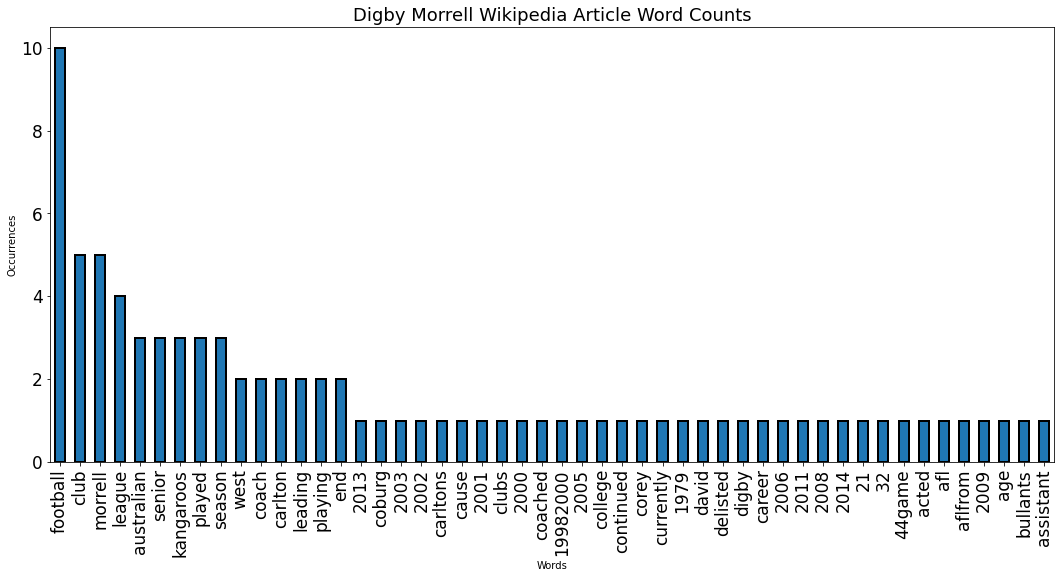

In [16]:
digby_counter = inspect_article_word_count(wiki, 'Digby Morrell', num_words=50)
print(digby_counter)

### Inspect article TF-IDF with keyword search

In [17]:
def plot_tf_idf_keyword(name, wiki):
    """
    This function inspects the top word importance tf-idf for a given keyword (name) 
    
    Input
        - wiki: pandas dataframe containing the wikipedia datast
        - keyword: name keyword to search in the dataset
        - num_words = number of words to report
    Output
        - word_counter: tf-idf counts
    """
    # Apply this vectorizer to the full dataset to create normalized vectors
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf =True, stop_words = 'english')

    # tfidf_vectorizer.fit: Learn vocabulary and idf from training set.
    tfidf_matrix = tfidf_vectorizer.fit_transform(wiki.text.values)

    # tfidf_vectorizer.get_feature_names(): Array mapping from feature integer indices to feature name
    features = tfidf_vectorizer.get_feature_names()

    # Get the row that belongs to name
    row = wiki[wiki.name==name].index.tolist()[0]

    # Create a series from the sparse matrix
    clinton_matrix = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(),index = features).sort_values(ascending=False)
    tf_idf_plot = clinton_matrix[:20].plot(kind='bar', title= name+' Wikipedia Article Word TF-IDF Values',
                figsize=(10,6), alpha=1, fontsize=14, rot=80,edgecolor='black', linewidth=2 )
    tf_idf_plot.title.set_size(18)
    tf_idf_plot.set_xlabel('WORDS')
    tf_idf_plot.set_ylabel('TF-IDF')

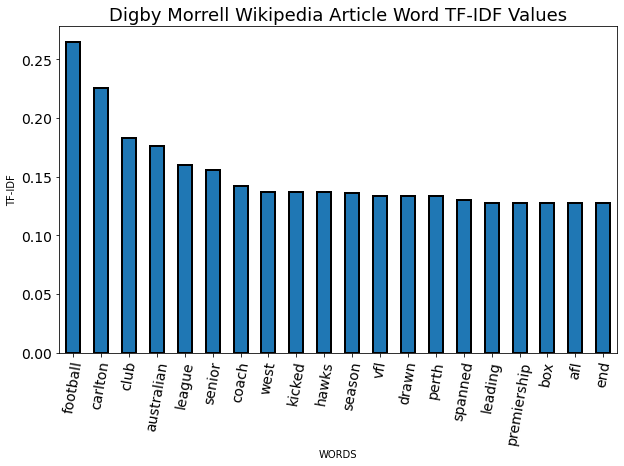

In [18]:
name = 'Digby Morrell'#'Mike LaValliere'
wiki_copy = wiki.copy()
plot_tf_idf_keyword(name, wiki)

## Extract word count vectors

As we have seen in the 'Predicting Product sentiment' notebook.

In [19]:
import string 
def remove_punctuation(text):
    """
    This function removes punction for text
    Input
        - text: text data to remove punctuation
    Output
        - text: updates text data 
    """
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

In [20]:
wiki['text'] = wiki['text'].apply(remove_punctuation)
print(wiki['text'])

0      digby morrell born 10 october 1979 is a former...
1      alfred j lewy aka sandy lewy graduated from un...
2      harpdog brown is a singer and harmonica player...
3      franz rottensteiner born in waidmannsfeld lowe...
4      henry krvits born 30 december 1974 in tallinn ...
                             ...                        
995    ren tantely gabrio andrianarivo born 25 may 19...
996    sir michael terence terry wogan kbe dl born 3 ...
997    michael eugene mike lavalliere born august 18 ...
998    benjamin vogt is a poet and essayist from linc...
999    neil patrick fallon october 25 1971 in portsmo...
Name: text, Length: 1000, dtype: object


Encode Word Counts

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(wiki['text'])
print(X_train_counts.shape)

word_count_df = pd.DataFrame(X_train_counts.toarray())
word_count_df = word_count_df.add_prefix('word_count_')
wiki = pd.concat([wiki, word_count_df], axis=1)

(1000, 34221)


Encode TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(wiki['text'])

tf_idf_word_count_df = pd.DataFrame(X_train_tfidf.toarray())
tf_idf_word_count_df = tf_idf_word_count_df.add_prefix('tf_idf_word_count_')
wiki = pd.concat([wiki, tf_idf_word_count_df], axis=1)

# Build vocabulary of words
word_vocabulary = vectorizer.get_feature_names()

## Split data into training and test sets

Usually, we'd split the dataset into train and test sets but given that we have no labels (not so lucky), for the sake of demonstration, we will use all the data for training and use the article name as the cluster. Therefore, all articles are there own cluster in terms of labels y. This is not recommended in practice.

In [23]:
from sklearn.model_selection import train_test_split

X_word_count = wiki.loc[:, wiki.columns.str.startswith('word_count_')] # Use word count
X_word_count

,word_count_0,word_count_1,word_count_2,word_count_3,word_count_4,word_count_5,word_count_6,word_count_7,word_count_8,word_count_9,...,word_count_34211,word_count_34212,word_count_34213,word_count_34214,word_count_34215,word_count_34216,word_count_34217,word_count_34218,word_count_34219,word_count_34220
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# TF-IDF encode words form documents
X_tfidf = wiki.loc[:, wiki.columns.str.startswith('tf_idf_word_count_')] # Use tf-idf
X_tfidf

,tf_idf_word_count_0,tf_idf_word_count_1,tf_idf_word_count_2,tf_idf_word_count_3,tf_idf_word_count_4,tf_idf_word_count_5,tf_idf_word_count_6,tf_idf_word_count_7,tf_idf_word_count_8,tf_idf_word_count_9,...,tf_idf_word_count_34211,tf_idf_word_count_34212,tf_idf_word_count_34213,tf_idf_word_count_34214,tf_idf_word_count_34215,tf_idf_word_count_34216,tf_idf_word_count_34217,tf_idf_word_count_34218,tf_idf_word_count_34219,tf_idf_word_count_34220
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Integer Encode cluster names
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
wiki['y'] = ord_enc.fit_transform(wiki[["name"]])
y = wiki['y']
print('Integer encoded cluster names'.format(wiki[["name", 'y']].head(11)))

Integer encoded cluster names


# k-Nearest Neighbors

Let's start by finding the nearest neighbors using the word count vectors to represent the articles and Euclidean distance to measure distance.  

kNN Parameters
* n_neighbors (int): Number of neighbors to use by default for kneighbors queries; default=5
* radius (float): Range of parameter space to use by default for radius_neighbors queries; default=1.0
* algorithm: Algorithm used to compute the nearest neighbors:
    - default: ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method
    - ‘ball_tree’ will use BallTree
    - ‘kd_tree’ will use KDTree
    - ‘brute’ will use a brute-force search.

Set NN Hyperparamters

In [26]:
num_neighhbors = 3 # minimium = 2
nn_algorithm = 'auto'
radius = 0.4

Let's start by finding the nearest neighbors on a subset of the dataset. Find k nearest neighbors for first n=3 articles

In [27]:
from sklearn.neighbors import NearestNeighbors
n_start_articles=0
n_end_articles=3

X_subset = X_tfidf[n_start_articles:n_end_articles]
y_subset = np.array(y[n_start_articles:n_end_articles])

nbrs = NearestNeighbors(n_neighbors=num_neighhbors, algorithm=nn_algorithm, radius=radius)
nbrs.fit(X_tfidf)

NearestNeighbors(n_neighbors=3, radius=0.4)

In [28]:
cluster_distances, cluster_neighbors = nbrs.kneighbors(X_subset, num_neighhbors, return_distance=True)
print('The nearest neighbor clusters distances are: \n{}'.format(cluster_distances))
print('The nearest neighbor clusters indexes are: \n{}'.format(cluster_neighbors))

The nearest neighbor clusters distances are: 
[[0.00000000e+00 1.05740826e+00 1.06588686e+00]
 [0.00000000e+00 1.29945577e+00 1.33400710e+00]
 [2.58095683e-08 1.26579328e+00 1.27856702e+00]]
The nearest neighbor clusters indexes are: 
[[  0 806 621]
 [  1  83 172]
 [  2 243   7]]


The neighbors are the indexes of the k nearest neighbors, formated as 
- sample 1 [neighbor 1 = 0, neighbor 2 = 806, ..., neighbor num_neighhbors]
- sample 2 [neighbor 1 = 1, neighbor 3 = 83, ..., neighbor num_neighhbors]
- sample 3 [neighbor 2 = 2, neighbor 3 = 243, ..., neighbor num_neighhbors]

Note that the closest neighbor for example is 'itself' i.e., sample 1 closest neighbor is 0, sample 2 closest neighbor is 1, and so on.

In [29]:
from sklearn.metrics import mean_squared_error, accuracy_score

print('RMSE for first neighbor: {}'.format(mean_squared_error(cluster_neighbors[:,1],y_subset, squared=False)))
print('Accuracy for second neighbor: {}'.format(accuracy_score(cluster_neighbors[:,1],y_subset)))

print('RMSE for second neighbor: {}'.format(mean_squared_error(cluster_neighbors[:,2],y_subset, squared=False)))
print('Accuracy for second neighbor: {}'.format(accuracy_score(cluster_neighbors[:,2],y_subset)))

RMSE for first neighbor: 321.7167491236144
Accuracy for second neighbor: 0.0
RMSE for second neighbor: 309.0474612957261
Accuracy for second neighbor: 0.0


Now, let's use the entire dataset for nearest neighbors

In [30]:
# Train NN
nbrs = NearestNeighbors(n_neighbors=num_neighhbors, algorithm=nn_algorithm, radius=radius)
nbrs.fit(X_tfidf)

# Print clusters
distances, indices = nbrs.kneighbors(X_tfidf)
print(indices)

[[  0 806 621]
 [  1  83 172]
 [  2 243   7]
 ...
 [997 570 245]
 [998 929 294]
 [999 112 691]]


Keep in mind that we don't have labels we consider all articles as their own cluster. This is not recommended in practice.

In [31]:
get_neighbor=1
n_neighbor=[]
for cd, cn in zip(cluster_distances,cluster_neighbors):
    cluster_num = cn[0]
    n_neighbor.append(cn[get_neighbor])
print('There nearest neigbhors of {} are {}'.format(wiki['name'][cluster_num], 
                                                      wiki['name'][n_neighbor[:5]]))

There nearest neigbhors of Harpdog Brown are 806      David Ellard
83     Robert S. Gold
243        Brett Hull
Name: name, dtype: object


Neil Fallon (born October 25, 1971) is an American musician, best known as the lead singer and occasional rhythm guitarist and keyboardist for the rock band Clutch. 

Neil Fallon's Neighbors
* David Ellard is a former professional Australian rules footballer who played for the Carlton Football Club in the Australian Football League (AFL).

* Robert S. Gold is a researcher in computer technology to health education and health promotion and founding dean of the University of Maryland School of Public Health (UMD SPH).

* Brett Hull is a Canadian–American former ice hockey player and general manager, and currently an executive vice president of the St. Louis Blues of the National Hockey League (NHL). 

* Alan Edwin Baxter was an American film and television actor.

* Owen Temple is an American folk and country music songwriter and musician based in Austin, Texas.

In [32]:
def get_closest_knn_neighbors(X, num_neighhbors, wiki, print_examples=5):
    """
    Print nearest neighbors names
    Input
        - X: word encoded features
        - num_neighbors: number of neighbors
        - wiki: pandas dataframe containing the wikipedia datast
        - print_examples: number of exampls to display
    Output
        - cluster_distances: cluster distances
        - cluster_neighbors: cluster neighbors 
    """
    i=0
    cluster_distances, cluster_neighbors = nbrs.kneighbors(X, num_neighhbors, return_distance=True)
    for cd, cn in zip(cluster_distances,cluster_neighbors):
        cluster_num = cn[0]
        for neighbor, distance in zip(cn, cd):
            if(cluster_num==neighbor):
                continue # ignore self
            if(i<=print_examples):
                print('Cluster {} has nearest neighbor {} at {}'.format(wiki['name'][cluster_num],
                                                                        wiki['name'][neighbor],
                                                                        distance))
            i+=1
    return cluster_distances, cluster_neighbors

In [33]:
cluster_distances, cluster_neighbors = get_closest_knn_neighbors(X_tfidf,num_neighhbors,wiki)

Cluster Digby Morrell has nearest neighbor David Ellard at 1.0574082586123599
Cluster Digby Morrell has nearest neighbor Rhys O'Keeffe at 1.0658868579637621
Cluster Alfred J. Lewy has nearest neighbor Robert S. Gold at 1.2994557735548447
Cluster Alfred J. Lewy has nearest neighbor Antonello Bonci at 1.3340070951054435
Cluster Harpdog Brown has nearest neighbor Brett Hull at 1.265793280886146
Cluster Harpdog Brown has nearest neighbor Trevor Ferguson at 1.2785670244049754


Let's explore the cluster neighbors for Digby Morrell, Alfred J. Lewy, and Harpdog Brown.

Digby Morrell is a former Australian rules footballer who played with the Kangaroos and Carlton in the Australian Football League (AFL).
* 1st neighbor: David Ellard is a former professional Australian rules footballer who played for the Carlton Football Club in the Australian Football League (AFL).
* 2nd neighbor: Rhys O'Keeffe is a former professional Australian rules footballer with the Carlton Football Club in the Australian Football League (AFL).

We can see that Digby Morrell's neighbors are also football players.

Alfred J. Lewy is a full professor and Vice-Chair of the department of Psychiatry at the Oregon Health & Science University
* 1st neighbor: Robert S. Gold is a researcher in the application of computer technology to health education and health promotion. He was the founding dean of the University of Maryland School of Public Health (UMD SPH) and is the current chair of its Department of Epidemiology and Biostatistics.
* 2nd neighbor: Antonello Bonci is an Italian-American neurologist and a neuropsychopharmacologist specialized in the long-term effects of drug exposure on the brain. In August 2019, he became president of Global Institutes on Addictions Miami. Bonci was previously the scientific director of the National Institute on Drug Abuse and a professor at the University of California, San Francisco.

We can see that Alfred J. Lewy neighbors work in education.

Harpdog Brown was a Canadian singer and harmonica player who had been active in Canada's blues scene since 1982. 
* 1st neighbor: Brett Hull is a Canadian–American former ice hockey player and general manager, and currently an executive vice president of the St. Louis Blues of the National Hockey League (NHL). 
* 2nd neighbor: Trevor Ferguson is a Canadian novelist of fourteen novels and four plays. He has been called Canada's best novelist both in Books in Canada and the Toronto Star.

We can see that Harpdog Brown neighbors a former football player and novelist. Let's explore what words Harpdog Brown and Brett Hull have in common.

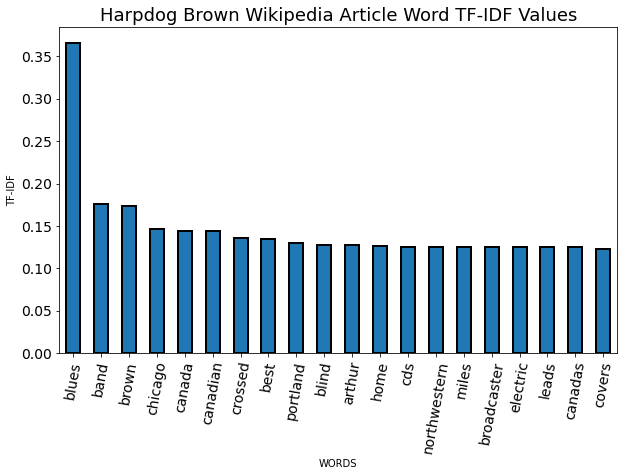

In [34]:
plot_tf_idf_keyword('Harpdog Brown', wiki)

Now, let's plot David Ellard TF-IDF word importance

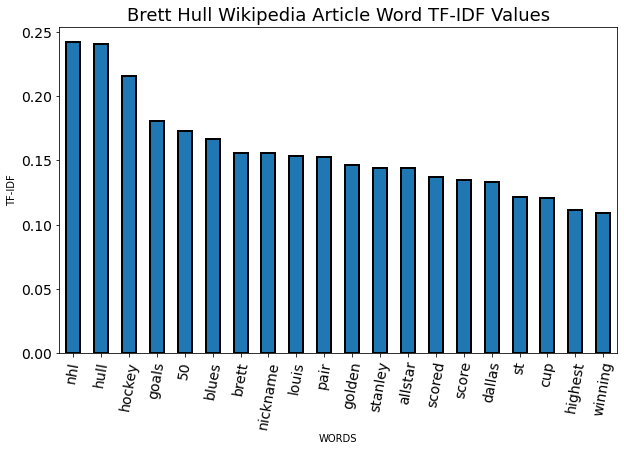

In [35]:
plot_tf_idf_keyword('Brett Hull', wiki)

Note, the words that Harpdog Brown and Brett Hull have in common e.g., blues and the many examples they do not have in common. 

In [36]:
cluster_distances

array([[0.00000000e+00, 1.05740826e+00, 1.06588686e+00],
       [0.00000000e+00, 1.29945577e+00, 1.33400710e+00],
       [2.58095683e-08, 1.26579328e+00, 1.27856702e+00],
       ...,
       [0.00000000e+00, 1.18637227e+00, 1.20044874e+00],
       [2.98023224e-08, 1.13117236e+00, 1.20122882e+00],
       [0.00000000e+00, 1.25130589e+00, 1.25816391e+00]])

Use RMSE and accuracy to evaluate the cluster assignments for the entire dataset. Keep in mind that we don't have labels we consider all articles as their own cluster. This is not recommended in practice.

In [37]:
nbrs = NearestNeighbors(n_neighbors=num_neighhbors, algorithm=nn_algorithm, radius=radius)
nbrs.fit(X_tfidf)

# Print clusters
cluster_distances, cluster_neighbors = nbrs.kneighbors(X_tfidf)

In [38]:
print('RMSE for first neighbor: {}'.format(mean_squared_error(cluster_neighbors[:,1],y, squared=False)))
print('Accuracy for second neighbor: {}'.format(accuracy_score(cluster_neighbors[:,1],y)))

print('RMSE for second neighbor: {}'.format(mean_squared_error(cluster_neighbors[:,2],y, squared=False)))
print('Accuracy for second neighbor: {}'.format(accuracy_score(cluster_neighbors[:,2],y)))

RMSE for first neighbor: 408.96043696181664
Accuracy for second neighbor: 0.001
RMSE for second neighbor: 399.52062524981113
Accuracy for second neighbor: 0.002


Think about why the RMSE is so high. Also, note that RMSE decreases with the second neighbors and the accuracy increases.

Find neighbors using word count 

In [39]:
nbrs = NearestNeighbors(n_neighbors=num_neighhbors, algorithm=nn_algorithm, radius=radius)
nbrs.fit(X_word_count)

# Print clusters
cluster_distances, cluster_neighbors = nbrs.kneighbors(X_word_count)
print(indices)

[[  0 806 621]
 [  1  83 172]
 [  2 243   7]
 ...
 [997 570 245]
 [998 929 294]
 [999 112 691]]


In [40]:
cluster_distances, cluster_neighbors = get_closest_knn_neighbors(X_word_count,num_neighhbors,wiki)

Cluster Digby Morrell has nearest neighbor Shane Valenti at 21.702534414210707
Cluster Digby Morrell has nearest neighbor Rhys O'Keeffe at 21.88606862823929
Cluster Alfred J. Lewy has nearest neighbor Victor Clube at 22.315913604421397
Cluster Alfred J. Lewy has nearest neighbor Bo Hampton at 22.38302928559939
Cluster Harpdog Brown has nearest neighbor Holter Graham at 22.06807649071391
Cluster Harpdog Brown has nearest neighbor Mammootty at 22.293496809607955


In [41]:
print('RMSE for first neighbor: {}'.format(mean_squared_error(cluster_neighbors[:,1],y, squared=False)))
print('Accuracy for second neighbor: {}'.format(accuracy_score(cluster_neighbors[:,1],y)))

print('RMSE for second neighbor: {}'.format(mean_squared_error(cluster_neighbors[:,2],y, squared=False)))
print('Accuracy for second neighbor: {}'.format(accuracy_score(cluster_neighbors[:,2],y)))

RMSE for first neighbor: 407.4670821060273
Accuracy for second neighbor: 0.0
RMSE for second neighbor: 397.7025747967946
Accuracy for second neighbor: 0.0


https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# k-means with text data

This section on k-means Neighbors covers:
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters

k-means Parameters
* n_neighbors (int): number of neighbors
* n_init (‘auto’ or int): Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia. Several runs are recommended for sparse high-dimensional problems
* init (str): callable or array-like of shape (n_clusters, n_features), default=’k-means++’. Method for initialization:
    - ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence. 
    - ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.  
* max_iter (int): Maximum number of iterations of the k-means algorithm for a single run. default=300
* random_state (int): Determines random number generation for centroid initialization. default=None
* algorithm (str): algorithm used to compute the k-means. The classical EM-style algorithm is "lloyd". However it’s more memory intensive due to the allocation of an extra array of shape (n_samples, n_clusters). default=”lloyd” 

Initialize k-means parameters

In [42]:
n_neighbors=3
algorithm=''
random_state=42
init='random'
max_iter=300

Train k-means

In [43]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_neighbors, random_state=random_state, init=init).fit(X_tfidf)

Inspect cluster assignments for first 10 examples

In [44]:
y_pred = kmeans.labels_
print(y_pred[:10])

[1 0 0 0 0 0 0 0 0 2]


Predict using cluster centers for first 10 examples (output should be the same as above)

In [45]:
kmeans.predict(X_tfidf[:10])

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

Inspect cluster centers

In [46]:
kmeans.cluster_centers_[:10]

array([[-6.09863722e-20,  1.49077799e-19,  9.66784827e-05, ...,
         1.25359876e-04,  1.29090028e-04,  7.93843432e-04],
       [ 2.60115313e-04,  4.74338450e-20,  2.71050543e-20, ...,
        -2.71050543e-20,  5.42101086e-20, -2.16840434e-19],
       [-3.38813179e-20,  3.24407535e-04, -1.35525272e-20, ...,
        -6.77626358e-20,  4.06575815e-20,  0.00000000e+00]])

Evaluate k-means in terms of sum-of-squares, silhouette scores, davies bouldin scores, and calinski harabasz scores

In [47]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score

def evaluate_k_means(X, max_iter=200, n_init=10, max_k=30):
    """
    Evaluate k-means on X data with increasing number of cluster centers
    
    Input
        - X: input word encoded features
        - max_iter: maximum iterations to run k-means
        - n_init: number of times the k-means algorithm is run with different centroid seeds
        - max_k: maximum k value for k-means
    Output
        - results: dictionary with results
        - K: number of data points
    """
    results={}
    sum_of_squared_distances = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    K = range(2,max_k)

    for k in K:
        km = KMeans(n_clusters=k, max_iter=max_iter, n_init=n_init)
        km = km.fit(X)

        y_pred = km.labels_
        silhouette_scores.append(silhouette_score(X, y_pred))
        davies_bouldin_scores.append(davies_bouldin_score(X, y_pred))
        calinski_harabasz_scores.append(calinski_harabasz_score(X, y_pred))
        sum_of_squared_distances.append(km.inertia_) # Sum of squared distances of samples to their closest cluster center

    results['sum_of_squared_distances'] = sum_of_squared_distances
    results['silhouette_scores'] = silhouette_scores
    results['davies_bouldin_scores'] = davies_bouldin_scores
    results['calinski_harabasz_scores'] = calinski_harabasz_scores
    return results, K

In [48]:
kmeans_results, K = evaluate_k_means(X_tfidf, max_iter=200, n_init=10, max_k=30)

In [49]:
import matplotlib.pyplot as plt

def plot_figures(data, xtitle, ytitle, K):
    """
    Plot figures using input data
    Input
        - data: data to plot (list or array)
        - xtitle: x-axis title (string)
        - ytitle: y-axis title (string)
        - K: number of observation
    Output
        - None; show figure
    """
    plt.plot(K, data, 'bx-')
    plt.xlabel('k')
    plt.ylabel(ytitle)
    plt.title(xtitle)
    plt.show()

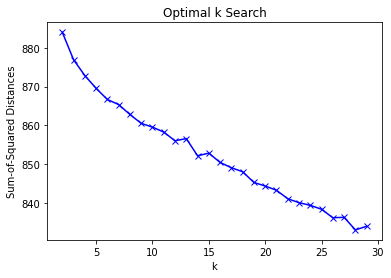

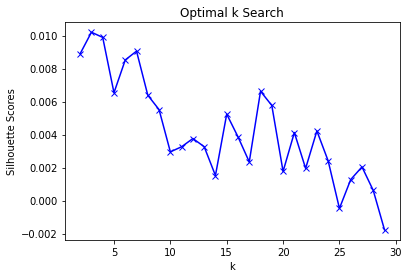

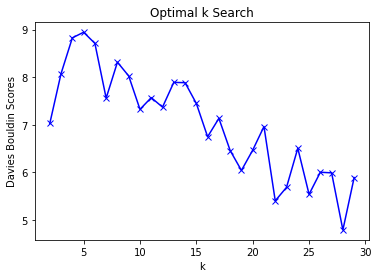

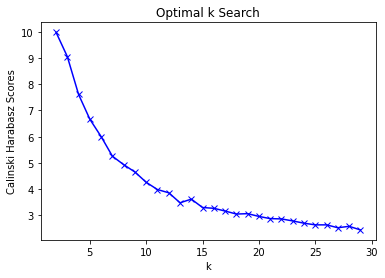

In [50]:
plot_figures(kmeans_results['sum_of_squared_distances'], 'Optimal k Search', 'Sum-of-Squared Distances', K)
plot_figures(kmeans_results['silhouette_scores'], 'Optimal k Search', 'Silhouette Scores', K)
plot_figures(kmeans_results['davies_bouldin_scores'], 'Optimal k Search', 'Davies Bouldin Scores', K)
plot_figures(kmeans_results['calinski_harabasz_scores'], 'Optimal k Search', 'Calinski Harabasz Scores', K)

Note, that the SoS and Calinski have stable, smooth curves while Silhoutte and Davies scores show a downward trend, but instability in terms of monotonically decreasing. 

## Impact of Initization method for k-means

In [52]:
def evaluate_k_means_initialization(X, init, n_clusters=3, max_iter=200, n_init=10):
    """
    The function runs k-means with increasing max iterations using fixed number of clusters
    Input
        - X: input word encoded features
        - n_clusters: number of clusters
        - max_iter: maximum iterations to run k-means
        - n_init: number of times the k-means algorithm is run with different centroid seeds
    Output
        - results: dictionary containing the results in sum_of_squared_distances, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores
    """
    results={}
    sum_of_squared_distances = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    max_iterations = range(1,max_iter,10)
    
    for mi in max_iterations:
        km = KMeans(n_clusters=n_clusters, max_iter=mi, n_init=n_init, init=init)
        km = km.fit(X)

        y_pred = km.labels_
        silhouette_scores.append(silhouette_score(X, y_pred))
        davies_bouldin_scores.append(davies_bouldin_score(X, y_pred))
        calinski_harabasz_scores.append(calinski_harabasz_score(X, y_pred))
        sum_of_squared_distances.append(km.inertia_) # Sum of squared distances of samples to their closest cluster center

    results['sum_of_squared_distances'] = sum_of_squared_distances
    results['silhouette_scores'] = silhouette_scores
    results['davies_bouldin_scores'] = davies_bouldin_scores
    results['calinski_harabasz_scores'] = calinski_harabasz_scores
    return results, max_iterations

In [53]:
kmeans_results_initialization, max_iterations = evaluate_k_means_initialization(X_tfidf, 'random', n_clusters=3, max_iter=600, n_init=10)

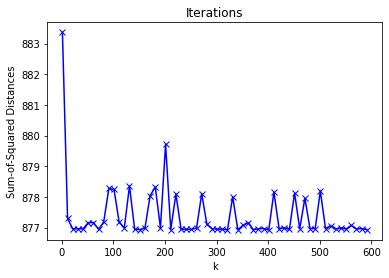

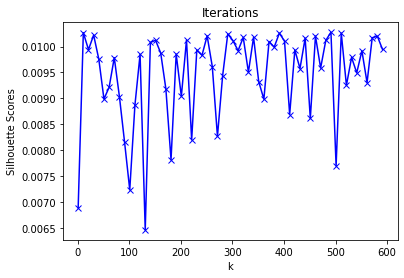

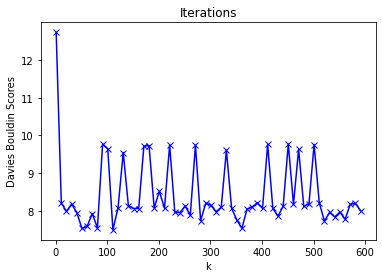

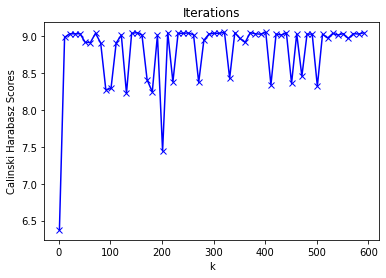

In [54]:
plot_figures(kmeans_results_initialization['sum_of_squared_distances'], 'Iterations','Sum-of-Squared Distances', max_iterations)
plot_figures(kmeans_results_initialization['silhouette_scores'], 'Iterations','Silhouette Scores', max_iterations)
plot_figures(kmeans_results_initialization['davies_bouldin_scores'], 'Iterations','Davies Bouldin Scores', max_iterations)
plot_figures(kmeans_results_initialization['calinski_harabasz_scores'], 'Iterations','Calinski Harabasz Scores', max_iterations)

Evaluation k-means: To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the inertia metric:

In [ ]:
kmeans_results_initialization, max_iterations = evaluate_k_means_initialization(X_tfidf, 'k-means++', n_clusters=4, max_iter=600, n_init=10)

In [ ]:
plot_figures(kmeans_results_initialization['sum_of_squared_distances'], 'Iterations','Sum-of-Squared Distances', max_iterations)
plot_figures(kmeans_results_initialization['silhouette_scores'], 'Iterations','Silhouette Scores', max_iterations)
plot_figures(kmeans_results_initialization['davies_bouldin_scores'], 'Iterations','Davies Bouldin Scores', max_iterations)
plot_figures(kmeans_results_initialization['calinski_harabasz_scores'], 'Iterations','Calinski Harabasz Scores', max_iterations)

https://www.kaggle.com/code/niramay/kmeans-clustering-wikipedia-articles